In [1]:
!python -m pip install -U scikit-learn

     ---------------------------------------- 8.3/8.3 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!python -m pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install seaborn

     -------------------------------------- 293.3/293.3 kB 2.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import mediapipe as mp

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_styled_landmarks(image, results):

    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [17]:
# Path for exported data, numpy arrays
DATA_PATH = 'F:\\MAIN PROJECT DATASET\\data'

# Actions that we try to detect
actions = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','S','T','U','V','W','X','Y','Z'])


In [18]:

# Thirty videos worth of data
no_sequences = 120

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
sequences, labels = [], []
for action in actions: 
    for sequence in range(start_folder,start_folder+no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    print("completed:"+action+"\n")

completed:A

completed:B

completed:C

completed:D

completed:E

completed:F

completed:G

completed:H

completed:I

completed:J

completed:K

completed:L

completed:M

completed:N

completed:O

completed:P

completed:Q

completed:S

completed:T

completed:U

completed:V

completed:W

completed:X

completed:Y

completed:Z



In [21]:
np.array(sequences).shape

(3000, 30, 126)

In [22]:
X = np.array(sequences)

In [23]:
y = to_categorical(labels).astype(int)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y)

# Building and Training LSTM Neural Network

## Load the model if already saved

In [25]:
from tensorflow import keras
model = keras.models.load_model('action.h5')

OSError: SavedModel file does not exist at: action.h5/{saved_model.pbtxt|saved_model.pb}

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [27]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [28]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
model.fit(X_train, y_train, epochs=250)

Epoch 1/250
85/85 [==============================] - 7s 43ms/step - loss: 3.0975 - categorical_accuracy: 0.0792
Epoch 2/250
85/85 [==============================] - 4s 52ms/step - loss: 2.4520 - categorical_accuracy: 0.1534
Epoch 3/250
85/85 [==============================] - 5s 55ms/step - loss: 2.2621 - categorical_accuracy: 0.2296
Epoch 4/250
85/85 [==============================] - 4s 45ms/step - loss: 1.9916 - categorical_accuracy: 0.2663
Epoch 5/250
85/85 [==============================] - 4s 51ms/step - loss: 2.3580 - categorical_accuracy: 0.3009
Epoch 6/250
85/85 [==============================] - 5s 53ms/step - loss: 2.0333 - categorical_accuracy: 0.2775
Epoch 7/250
85/85 [==============================] - 4s 41ms/step - loss: 1.6755 - categorical_accuracy: 0.3883
Epoch 8/250
85/85 [==============================] - 4s 45ms/step - loss: 1.4687 - categorical_accuracy: 0.4499
Epoch 9/250
85/85 [==============================] - 4s 42ms/step - loss: 1.2693 - categorical_accuracy:

85/85 [==============================] - 3s 37ms/step - loss: 0.0543 - categorical_accuracy: 0.9851
Epoch 146/250
85/85 [==============================] - 3s 37ms/step - loss: 0.0721 - categorical_accuracy: 0.9825
Epoch 147/250
85/85 [==============================] - 3s 37ms/step - loss: 0.0478 - categorical_accuracy: 0.9834
Epoch 148/250
85/85 [==============================] - 3s 38ms/step - loss: 0.0594 - categorical_accuracy: 0.9823
Epoch 149/250
85/85 [==============================] - 3s 40ms/step - loss: 0.0698 - categorical_accuracy: 0.9810
Epoch 150/250
85/85 [==============================] - 3s 38ms/step - loss: 0.0128 - categorical_accuracy: 0.9947
Epoch 151/250
85/85 [==============================] - 3s 37ms/step - loss: 0.0601 - categorical_accuracy: 0.9818
Epoch 152/250
85/85 [==============================] - 3s 38ms/step - loss: 0.1168 - categorical_accuracy: 0.9659
Epoch 153/250
85/85 [==============================] - 3s 38ms/step - loss: 0.0375 - categorical_accur

KeyboardInterrupt: 

# Evaluation

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [57]:
yhat = model.predict(X_test)

In [58]:
ytrue = np.argmax(y_test, axis=1).tolist()
print(len(ytrue))
yhat = np.argmax(yhat, axis=1).tolist()
print(len(yhat))

300
300


In [77]:
result=np.round(confusion_matrix(ytrue, yhat)/12 ,2)

NameError: name 'result' is not defined

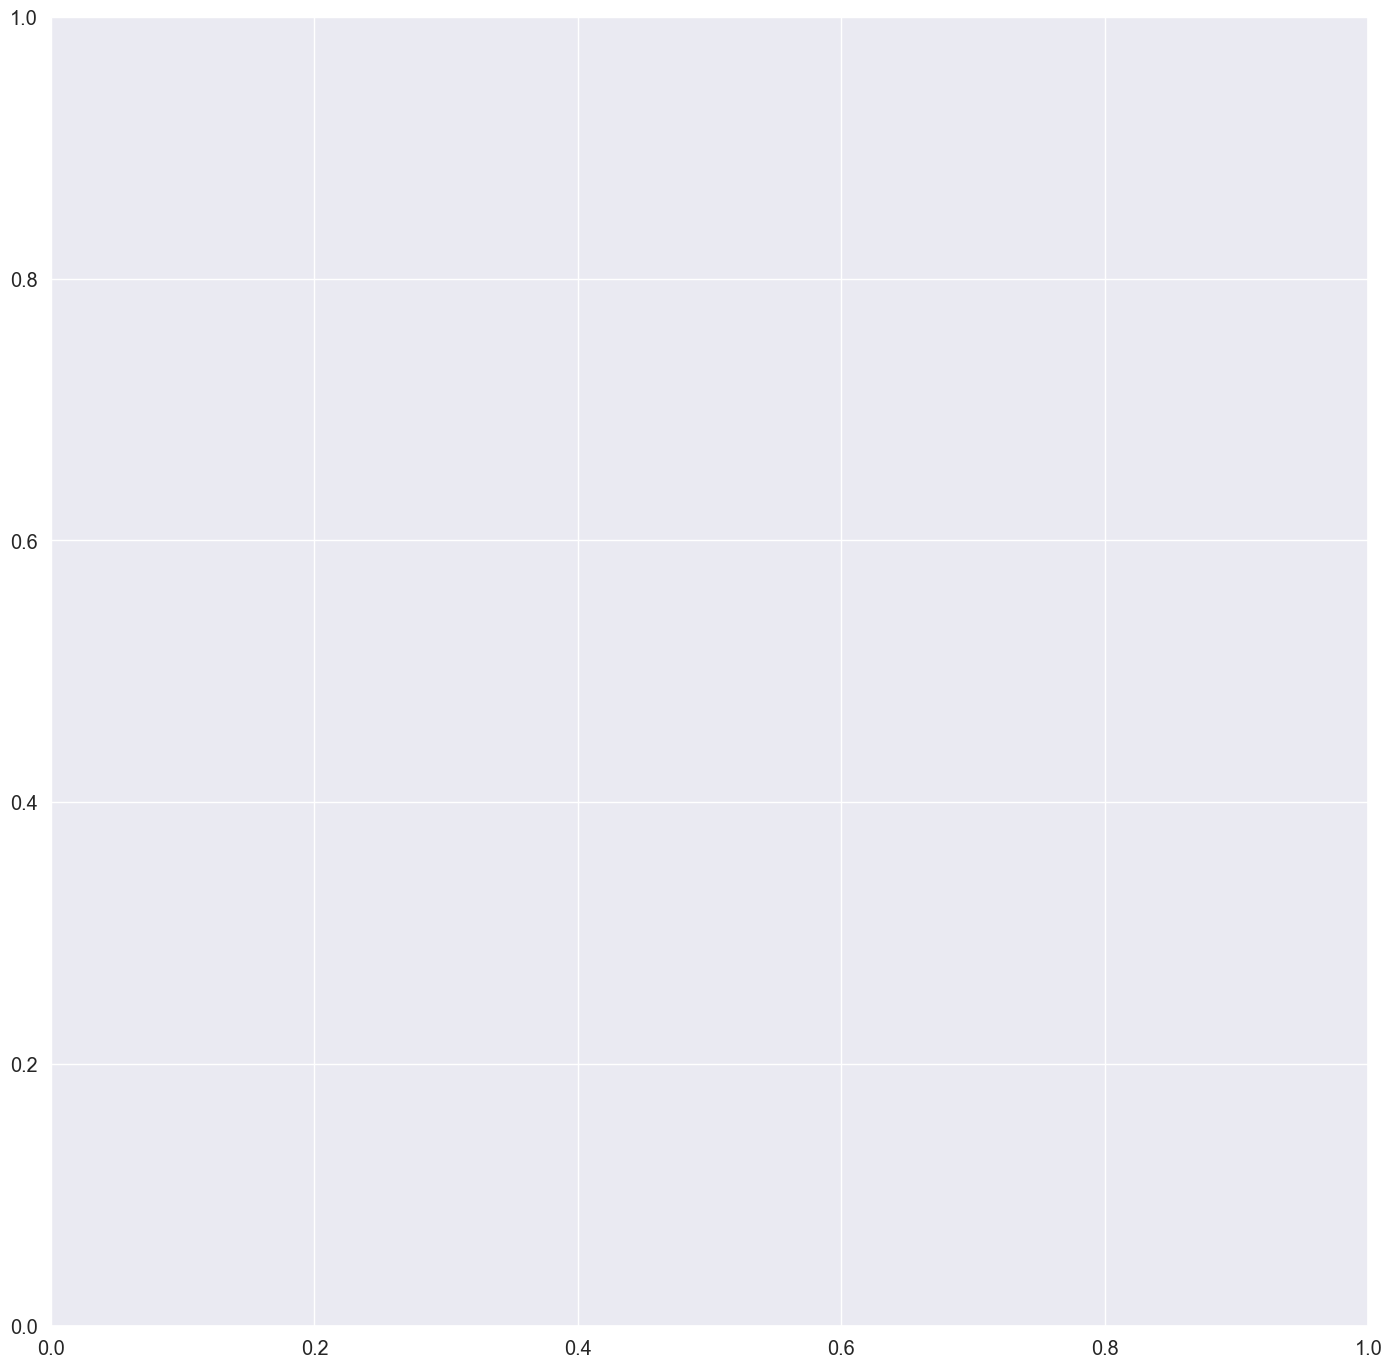

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,17))
sns.set(font_scale=1.3) 
sns.heatmap(result, annot=True, linewidth=.5,xticklabels=actions, yticklabels=actions,cmap="Blues",cbar_kws={"orientation": "vertical", "pad": 0.01})

In [80]:
accuracy_score(ytrue, yhat)

0.99

In [31]:
model.save('action.h5')

# Test In real Time

In [27]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
def display(image):
    while(True):
        
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    #while cap.isOpened():
    i=0;
    while(True):
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            cv2.putText(image, "Detected Sign: "+actions[np.argmax(res)], (320,80), 
                             cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
            display(image)
            break

        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [96]:
cap.release()
cv2.destroyAllWindows()